In [3]:
import numpy as np
import unittest

In [4]:
def load_data():
    X = np.matrix([[1.0, 2.1],
                   [2.0, 1.1],
                   [1.3, 1.0],
                   [1.0, 1.0],
                   [2.0, 1.0]])
    y = [1.0, 1.0, -1.0, -1.0, 1.0]
    return X, y

In [5]:
def classify_stump(X, dimension, threshold, thresh_inequality):
    X_arr = np.ones((np.shape(X)[0], 1))
    if thresh_inequality == 'lt':
        X_arr[X[:, dimension] <= threshold] = -1.0
    else:
        X_arr[X[:, dimension] > threshold] = -1.0
    return X_arr

In [6]:
def build_stump(X, y, D):
    X_mat = np.matrix(X)
    y_mat = np.matrix(y).T
    m, n = np.shape(X)
    
    num_steps = 10.0
    best_stump = {}
    best_class_estimator = np.mat(np.zeros((m, 1)))
    
    min_error = np.inf
    
    # For each of the features
    for i in range(n):
        range_min = X_mat[:, i].min()
        range_max = X_mat[:, i].max()
        
        step_size = (range_max - range_min) / num_steps
        for j in range(-1, int(num_steps) + 1):
            for inequal in ['lt', 'gt']:
                threshold = (range_min + float(j) * step_size)
                y_predicted = classify_stump(X_mat, i, threshold, inequal)
                err_arr = np.mat(np.ones((m, 1)))
                err_arr[y_predicted == y_mat] = 0
                weighted_error = D.T * err_arr
                if weighted_error < min_error:
                    min_error = weighted_error
                    best_class_estimator = y_predicted.copy()
                    best_stump['dim'] = i
                    best_stump['thresh'] = threshold
                    best_stump['ineq'] = inequal
    return best_stump, min_error, best_class_estimator

In [28]:
def adaboost_train_decision_stumps(X, y, epochs = 40):
    weak_class_arr = []
    m = np.shape(X)[0]
    D = np.mat(np.ones((m, 1)) / m)
    agg_class_estimator = np.mat(np.zeros((m, 1)))
    
    for i in range(epochs):
        best_stump, error, class_estimator = build_stump(X, y, D)
#         print('D:', D.T)
        
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))
        best_stump['alpha'] = alpha
        weak_class_arr.append(best_stump)
        
#         print('class_estimator:', class_estimator.T)
        
        expon = np.multiply(-1 * alpha * np.mat(y).T, class_estimator)
        
        D = np.multiply(D, np.exp(expon))
        D = D / D.sum()
        
        agg_class_estimator += alpha * class_estimator
#         print('agg_class_estimator:', agg_class_estimator.T)
        
        agg_errors = np.multiply(np.sign(agg_class_estimator) != np.mat(y).T, np.ones((m, 1)))
        error_rate = agg_errors.sum() / m
#         print('total_error:', error_rate)
    return weak_class_arr, agg_class_estimator

In [8]:
def ada_classifier(X, y):
    X_mat = np.mat(X)
    m = np.shape(X_mat)[0]
    agg_class_estimator = np.mat(np.zeros((m, 1)))
    for i in range(len(y)):
        class_estimator = classify_stump(X, y[i]['dim'], y[i]['thresh'], y[i]['ineq'])
        agg_class_estimator += y[i]['alpha'] * class_estimator
    return np.sign(agg_class_estimator)

In [27]:
def load_data2(file_name):
    with open(file_name) as f:
        lines = f.readlines()
        num_feat = 0
        
        X = []
        y = []
        
        for line in lines:
            num_feat += 1
            rows = line.strip().split('\t')
            X.append(np.array(rows[0:len(rows) - 1]).astype(float))
            y.append(np.array(rows[-1]).astype(float))
        f.close()
        return X, y

In [30]:
def plot_roc(y_predicted, y):
    import matplotlib.pyplot as plt
    cur = (1.0, 1.0)
    y_sum = 0.0
    num_pos_class = np.sum(np.array(y) == 1.0)
    y_step = 1 / np.float(num_pos_class)
    x_step = 1 / np.float(len(y) - num_pos_class)
    sorted_indices = y_predicted.argsort()
    
    fig = plt.figure()
    fig.clf()
    
    ax = plt.subplot(111)
    for index in sorted_indices.tolist()[0]:
        if y[index] == 1.0:
            del_X = 0
            del_y = y_step
        else:
            del_X = x_step
            del_y = 0
            y_sum += cur[1]
        ax.plot([cur[0], cur[0] - del_X], [cur[1], cur[1] - del_y], c = 'b')
        cur = (cur[0] - del_X, cur[1] - del_y)

    ax.plot([0, 1], [0, 1], 'b--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for AdaBoost Horse Colic Detection System')
    ax.axis([0, 1, 0, 1])
    plt.show()
    print('The area under the curve is: {}'.format(y_sum * x_step))
    

.....

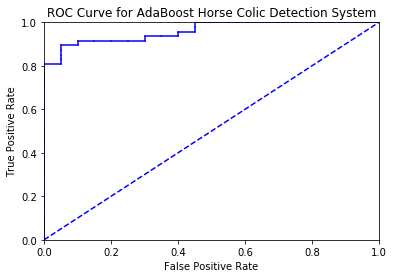

.

The area under the curve is: 0.9595744680851065



----------------------------------------------------------------------
Ran 6 tests in 0.663s

OK


In [33]:
class AdaBoostTestCase(unittest.TestCase):
    def test_load_data(self):
        X, y = load_data()
        self.assertEqual(len(X), len(y))
    
    def test_build_stump(self):
        X, y = load_data()
        D = np.mat(np.ones((5, 1))/ 5)
        
        best_stump, min_error, best_class_estimator = build_stump(X, y, D)
        self.assertDictEqual(best_stump, {'dim': 0, 'thresh': 1.3, 'ineq': 'lt'})
        self.assertEqual(min_error, np.matrix([[0.2]]))
        self.assertEqual(list(best_class_estimator), list([[-1.0], [1.0], [-1.0], [-1.0], [1.0]]))
    
    def test_adaboost_train_decision_stumps(self):
        X, y = load_data()
        out = adaboost_train_decision_stumps(X, y)
        self.assertTrue(len(out) != 0)
    
    def test_ada_classify(self):
        X, y = load_data()
        classifier, _ = adaboost_train_decision_stumps(X, y, 30)
        out = ada_classifier(np.array([[5.0, 5.0], [0.0, 0.0]]), classifier)
        self.assertTrue(len(out) != 0)
    
    def test_load_data2(self):
        X, y = load_data2('horseColicTest2.txt')
        self.assertTrue(len(X) == len(y))
    
    def test_plot_roc(self):
        X, y = load_data2('horseColicTest2.txt')
        classifier, agg_class_est = adaboost_train_decision_stumps(X, y, 10)
        plot_roc(agg_class_est.T, y)

if __name__ == '__main__':
    unittest.main(argv = ['ignore-first-arg'], exit = False)